# 한글 Word2Vec 만들기

In [1]:
# KoNLPy 설치
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 42.0 MB/s 


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep='\t')
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 데이터 전처리

In [4]:
# 중복 여부 확인
df.shape, df.document.nunique()

((200000, 3), 194543)

In [5]:
# 중복 데이터 배제
df.drop_duplicates(subset=['document'], inplace=True)
df.shape

(194544, 3)

In [6]:
# Null 데이터 있는지 확인
df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [7]:
# Null data 제거
df.dropna(how='any', inplace=True)

In [8]:
# 한글 이외의 문자는 공백으로 처리하고 strip
df.document = df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [11]:
# '' 만 남은 데이터 --> np.nan 으로 변경시킨 후 제거
df.document.replace('', np.nan, inplace=True)
df.document.isna().sum()

1025

In [12]:
# Null data 제거
df.dropna(how='any', inplace=True)
df.shape

(193518, 3)

### 한글 형태소 분석

In [19]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.',',','?','!','\'','"']

In [15]:
okt = Okt()
print(okt.morphs('토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.'))

['토큰', '화가', '된', '상태', '에서는', '각', '리뷰', '의', '길이', '분포', '또한', '확인', '이', '가능합니다', '.']


In [18]:
print(okt.morphs('토큰화가 된 상태에서는, 각 리뷰의 길이 "분포" 또한 확인이 가능합니다.', stem=True))

['토큰', '화가', '되다', '상태', '에서는', ',', '각', '리뷰', '의', '길이', '"', '분포', '"', '또한', '확인', '이', '가능하다', '.']


In [21]:
from tqdm.notebook import tqdm

tokenized_data = []
for sentence in tqdm(df.document):
    morphs = okt.morphs(sentence, stem=True)
    morphs = [word for word in morphs if word not in stopwords]     # 불용어 제거
    tokenized_data.append(morphs)

  0%|          | 0/193518 [00:00<?, ?it/s]

리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 11.04329829783276


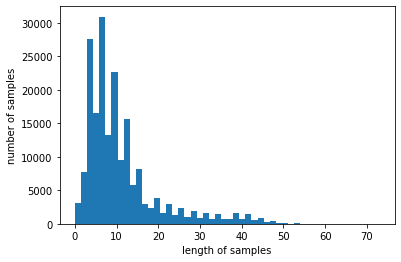

In [22]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :', max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec 훈련시키기

In [23]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [24]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16376, 100)

In [26]:
model.wv.most_similar("최민식", topn=5)

[('한석규', 0.8865979909896851),
 ('김명민', 0.8702331781387329),
 ('안성기', 0.8666921257972717),
 ('송강호', 0.8659419417381287),
 ('이정재', 0.8506866097450256)]

In [27]:
model.wv.most_similar("히어로", topn=5)

[('느와르', 0.8619754314422607),
 ('슬래셔', 0.8519841432571411),
 ('무협', 0.851790189743042),
 ('호러', 0.8442066311836243),
 ('무비', 0.8336305022239685)]

In [28]:
# 한국 - 서울 + 도쿄
# 영화평으로 학습을 해서 올바른 결과가 나오지 않음
model.wv.most_similar(positive=['한국','도쿄'], negative=['서울'], topn=3)

[('퀴어', 0.7140427827835083),
 ('보통', 0.6965163946151733),
 ('스포츠', 0.6605128049850464)]

In [30]:
# 황정민 - 느와르 + 멜로
model.wv.most_similar(positive=['황정민','멜로'], negative=['느와르'])

[('임수정', 0.7858409285545349),
 ('성유리', 0.784692645072937),
 ('유아인', 0.7695029973983765),
 ('이연희', 0.769203245639801),
 ('신민아', 0.7635611891746521),
 ('곽지민', 0.7633934617042542),
 ('박신혜', 0.7633332014083862),
 ('이민기', 0.7592660784721375),
 ('전도연', 0.7567380666732788),
 ('유해진', 0.7522698640823364)]